In [1]:
import numpy as np
from numpy.fft import fft, ifft, ifftshift, fftfreq
import matplotlib.pyplot as plt

In [2]:
def gaussian(x, mu, sigma):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-0.5 * np.square(x - mu) / np.square(sigma))
def gaussian_sigma(fwhm):
    return fwhm / (2 * np.sqrt(2 * np.log(2)))
def lorentzian(x, mu, fwhm):
    return (1/np.pi) * ((0.5*fwhm)/(np.square(x-mu) + np.square(0.5*fwhm)))
def regularized_reciprocal(z, alpha=0.5, epsilon=0.05, t=1):
    return (np.conjugate(z) * np.power(np.abs(z), alpha-1)) \
            / (np.power(np.abs(z), alpha+1) + np.power(epsilon*np.abs(t), alpha+1))

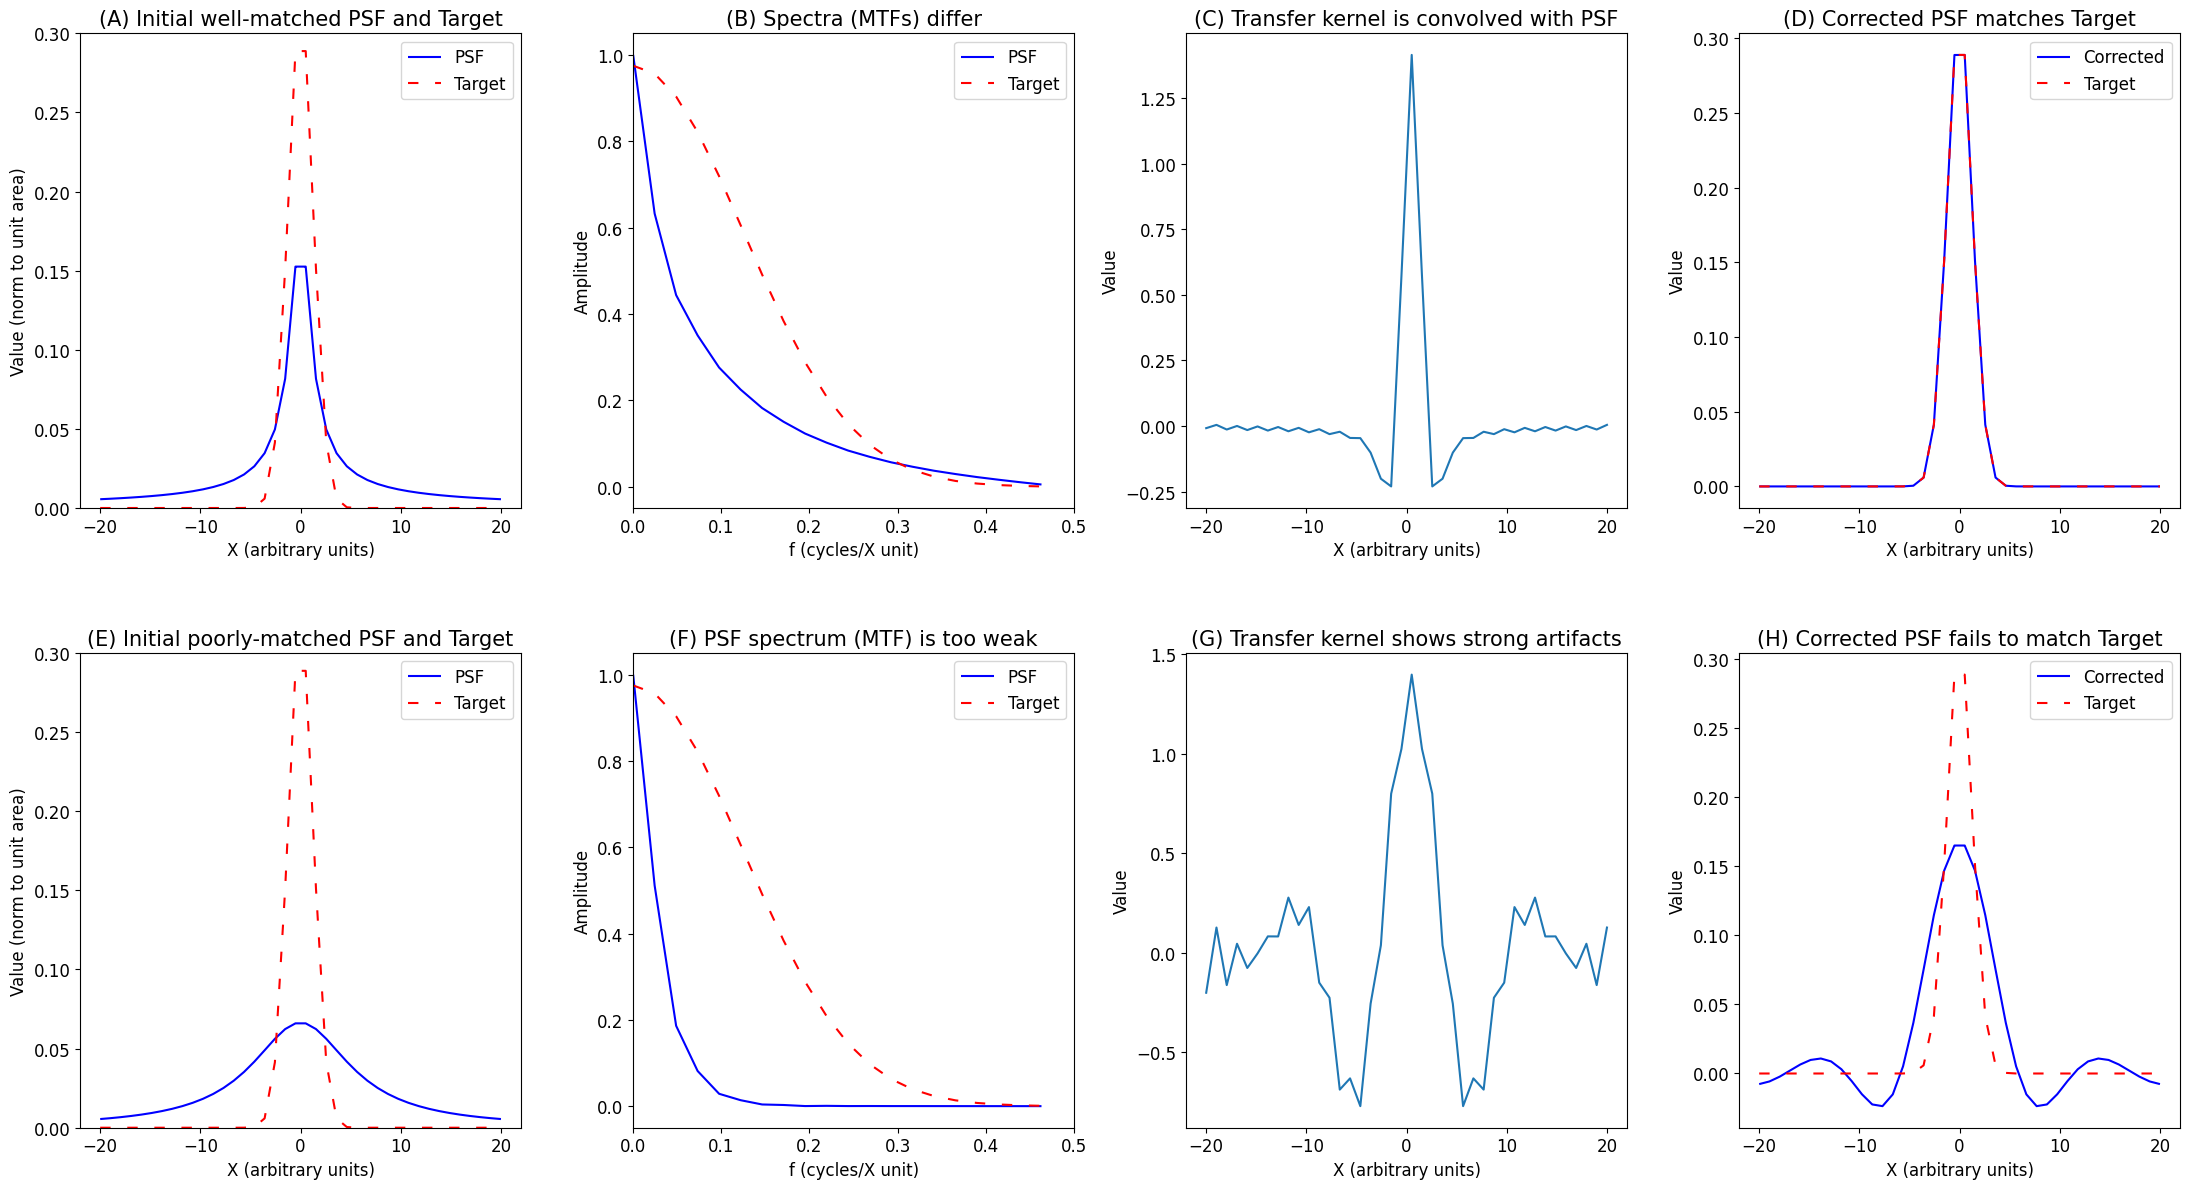

In [3]:
N = 40
x = np.linspace(-20, 20, N)
xf = fftfreq(N, d=x[1]-x[0])
alpha, epsilon = 3, 0.05

ts = [gaussian(x, 0, gaussian_sigma(3))]*2
ks = [np.sqrt(lorentzian(x, 0, 1.7))*0.5+lorentzian(x,0,2.5)*0.5, lorentzian(x, 0, 12)]
for i in range(2):
    ks[i] = ks[i] / np.sum(ks[i])
    
psf_style = "b-"
target_style = 'r--'
psf_dash_style = [1, 0]
target_dash_style = [5, 8]

import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
         'axes.labelsize': 12,
         'axes.titlesize': 15,
         'xtick.labelsize': 12,
         'ytick.labelsize': 12}
pylab.rcParams.update(params)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(22, 12))
for i, (t, k) in enumerate(zip(ts, ks)):
    
    # plot the target and the observed psf
    axs[i, 0].plot(x, k, psf_style, dashes=psf_dash_style, label='PSF')
    axs[i, 0].plot(x, t, target_style, dashes=target_dash_style, label='Target')
    axs[i, 0].legend()
    axs[i, 0].set_xlabel("X (arbitrary units)")
    axs[i, 0].set_ylabel("Value (norm to unit area)")
    axs[i, 0].set_ylim((0, 0.3))
    
    # plot the spectrum
    axs[i, 1].plot(xf[:N//2], np.abs(fft(k))[:N//2], psf_style, 
                   dashes=psf_dash_style, label='PSF')
    axs[i, 1].plot(xf[:N//2], np.abs(fft(t))[:N//2], target_style, 
                   dashes=target_dash_style, label='Target')
    axs[i, 1].set_xlim((0, 0.5))
    axs[i, 1].set_ylabel("Amplitude")
    axs[i, 1].set_xlabel("f (cycles/X unit)")
    axs[i, 1].legend()
    
    # plot the transfer psf
    k_inv = np.real(ifftshift(ifft(regularized_reciprocal(fft(k), alpha=alpha, epsilon=epsilon, t=fft(t))*fft(t))))
    axs[i, 2].plot(x, k_inv)
    axs[i, 2].set_xlabel("X (arbitrary units)")
    axs[i, 2].set_ylabel("Value")
    
    # plot the correction result
    corrected = np.real(ifft(fft(k)*regularized_reciprocal(fft(k), alpha=alpha, epsilon=epsilon, t=fft(t))*fft(t)))
    axs[i, 3].plot(x, corrected, psf_style, dashes=psf_dash_style, label='Corrected')
    axs[i, 3].plot(x, t, target_style, dashes=target_dash_style, label='Target')
    axs[i, 3].legend()
    axs[i, 3].set_xlabel("X (arbitrary units)")
    axs[i, 3].set_ylabel("Value")
    

axs[0, 0].set_title("(A) Initial well-matched PSF and Target")
axs[0, 1].set_title("(B) Spectra (MTFs) differ")
axs[0, 2].set_title("(C) Transfer kernel is convolved with PSF")
axs[0, 3].set_title("(D) Corrected PSF matches Target")

axs[1, 0].set_title("(E) Initial poorly-matched PSF and Target")
axs[1, 1].set_title("(F) PSF spectrum (MTF) is too weak")
axs[1, 2].set_title("(G) Transfer kernel shows strong artifacts")
axs[1, 3].set_title("(H) Corrected PSF fails to match Target")


fig.tight_layout(h_pad=5)
fig.savefig("../figures/8panel.png")